# Sheet 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import pyplot as plt

plt.rcParams['figure.dpi'] = 150

%matplotlib inline

## 1 Principal Component Analysis
### (a)

In [2]:
# TODO: implement PCA (fill in the blanks in the function below)

def pca(data, n_components=None):
    """
    Principal Component Analysis on a p x N data matrix.
    
    Parameters
    ----------
    data : np.ndarray
        Data matrix of shape (p, N).
    n_components : int, optional
        Number of requested components. By default returns all components.
        
    Returns
    -------
    np.ndarray, np.ndarray
        the pca components (shape (n_components, p)) and the projection (shape (n_components, N))

    """
    p = data.shape[0] 
    N = data.shape[1]
    # set n_components to p by default
    n_components = data.shape[0] if n_components is None else n_components
    assert n_components <= data.shape[0], f"Got n_components larger than dimensionality of data!"
    
    # center the data
    X = data - np.mean(data, axis=1).reshape((p,1))
    assert np.allclose(np.mean(X, axis=1), np.zeros(p), atol=1e-07) # check that X is centered
    # compute X times X transpose
    XX_t = X.dot(X.T)
    # compute the eigenvectors and eigenvalues
    # eigh return the eigenvals/vec of a real symm. matrix in ascending orde
    e_val, e_vec = np.linalg.eigh(XX_t)

    # sort the eigenvectors by eigenvalue and take the n_components largest ones
    e_vec = e_vec[:,::-1] # reverse the order of the columns (= vectors)
    
    components = (e_vec[:,:n_components]).T # rows of the components matrix are the transposed eigenvectors
    
    # compute X_projected, the projection of the data to the components
    X_projected = components.dot(X)
    
    return components, X_projected  # return the n_components first components and the pca projection of the data


In [3]:
# Example data to test your implementation 
# All the asserts on the bottom should go through if your implementation is correct

data = np.array([
    [ 1,  0,  0, -1,  0,  0],
    [ 0,  3,  0,  0, -3,  0],
    [ 0,  0,  5,  0,  0, -5]
], dtype=np.float32)

# add a random offset to all samples. it should not affect the results
data += np.random.randn(data.shape[0], 1)

n_components = 2
components, projection = pca(data, n_components=n_components)  # apply your implementation
# the correct results are known (up to some signs)
true_components = np.array([[0, 0, 1], [0, 1, 0]], dtype=np.float32)
true_projection = np.array([
    [ 0,  0,  5,  0,  0, -5],
    [ 0,  3,  0,  0, -3,  0]
], dtype=np.float32)

# check that components match, up to sign
assert isinstance(components, np.ndarray), f'Expected components to be numpy array but got {type(components)}'
assert components.shape == true_components.shape #, f'{out1[0].shape}!={out2[0].shape}'
assert np.allclose(np.abs(components * true_components).sum(1), np.ones(n_components)), f'Components not matching'

# check that projections agree, taking into account potentially flipped components
assert isinstance(projection, np.ndarray), f'Expected projection to be numpy array but got {type(projection)}'
assert projection.shape == (n_components, data.shape[1]), f'Incorrect shape of projection: Expected {(n_components, data.shape[1])}, got {projection.shape}'
assert np.allclose(projection, true_projection * (components * true_components).sum(1, keepdims=True), atol=1e-6), f'Projections not matching'

print('Test successful!')

Test successful!


### (b)

Load the data (it is a subset of the data at https://opendata.cern.ch/record/4910#)

In [4]:
features = np.load('data/dijet_features.npy')
labels = np.load('data/dijet_labels.npy')
label_names = ['b', 'c', 'q']  # bottom, charm or light quarks

print(f'{features.shape=}, {labels.shape=}')  # print the shapes

# TODO: print how many samples of each class are present in the data (hint: numpy.unique)
print(np.unique(labels, return_counts=True))
counts = np.unique(labels, return_counts=True)[1]
print(f'We have {counts[0]} samples of class b, {counts[1]} of class c and {counts[2]} samples of class q.')

features.shape=(116, 2233), labels.shape=(2233,)
(array([0., 1., 2.]), array([999, 864, 370]))
We have 999 samples of class b, 864 of class c and 370 samples of class q.


Normalize the data

In [5]:
# TODO: subtract the mean of each feature to center the data
centered = features - np.mean(features, axis=1).reshape((features.shape[0],1))
# TODO: divide by the standard deviation of each feature to normalize the variance
standardized = centered / (np.std(centered, axis=1).reshape((centered.shape[0],1)))

assert np.allclose(np.round(np.mean(standardized, axis=1), decimals=11), np.zeros((standardized.shape[0], 1)))
assert np.allclose(np.std(standardized, axis=1), np.ones((standardized.shape[0], 1)))

### (c)
Compute a 2D PCA projection and make a scatterplot of the result, once without color, once coloring the dots by label

In [6]:
# TODO: apply PCA as implemented in (a)
components, X_projected = pca(standardized, n_components=2)

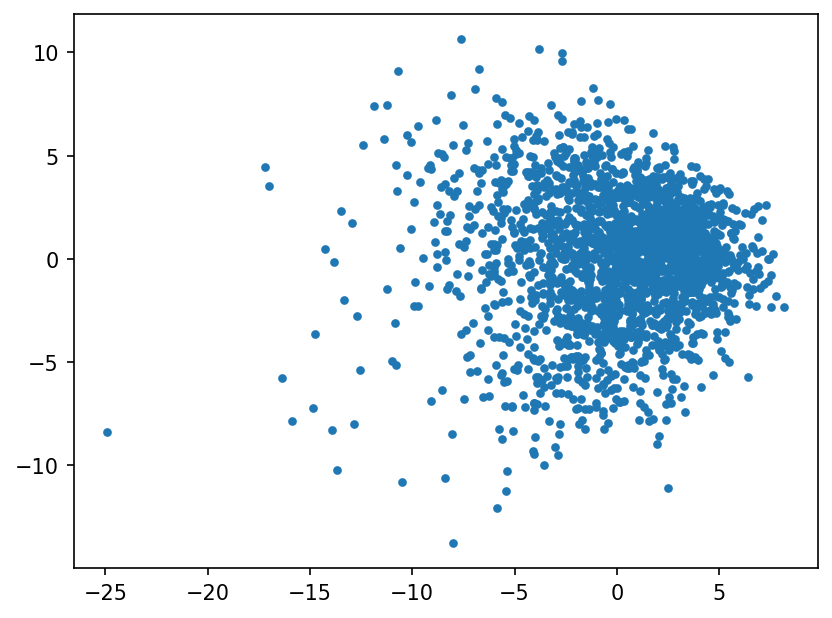

In [7]:
# TODO: make a scatterplot of the PCA projection
X_projected.shape
plt.scatter(x = X_projected[0,:], y = X_projected[1,:], s=10)

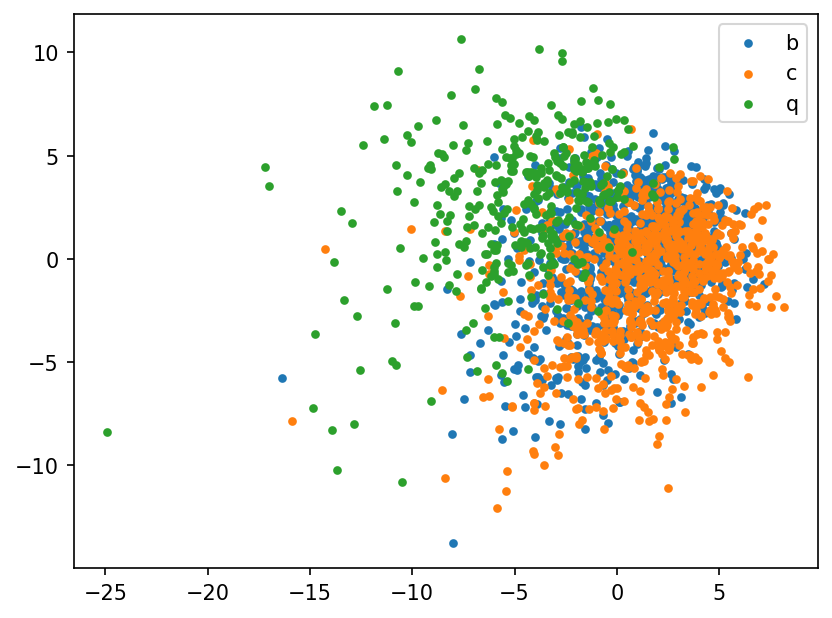

In [36]:
# TODO: make a scatterplot, coloring the dots by their label and including a legend with the label names
# (hint: one way is to call plt.scatter once for each of the three possible labels)
bs = X_projected.T[labels==0].T
cs = X_projected.T[labels==1].T
qs = X_projected.T[labels==2].T
projected = [bs, cs, qs]
label_names = ['b', 'c', 'q']

#plt.figure(dpi=150)
for quarks, label in zip(projected, label_names):
    plt.scatter(x = quarks[0,:], y = quarks[1,:], s=10, label = label)

plt.legend(loc='best')

## 2 Nonlinear Dimension Reduction

In [9]:
import umap  # import umap-learn, see https://umap-learn.readthedocs.io/

In [15]:
# if you have not done 1(b) yet, you can load the normalized features directly:
features = np.load('data/dijet_features_normalized.npy')
labels = np.load('data/dijet_labels.npy')
label_names = ['b', 'c', 'q']  # bottom, charm or light quarks

### (a)

In [21]:
# TODO: Apply umap on the normalized jet features from excercise 1. It will take a couple of seconds.
# note: umap uses a different convention regarding the feature- and sample dimension, N x p instead of p x N!

reducer = umap.UMAP()

In [34]:
features_t = features.T # umap uses Nxp

embedding = reducer.fit_transform(features_t)

b_embed = embedding[labels==0]
c_embed = embedding[labels==1]
q_embed = embedding[labels==2]

embeds = [b_embed, c_embed, q_embed]

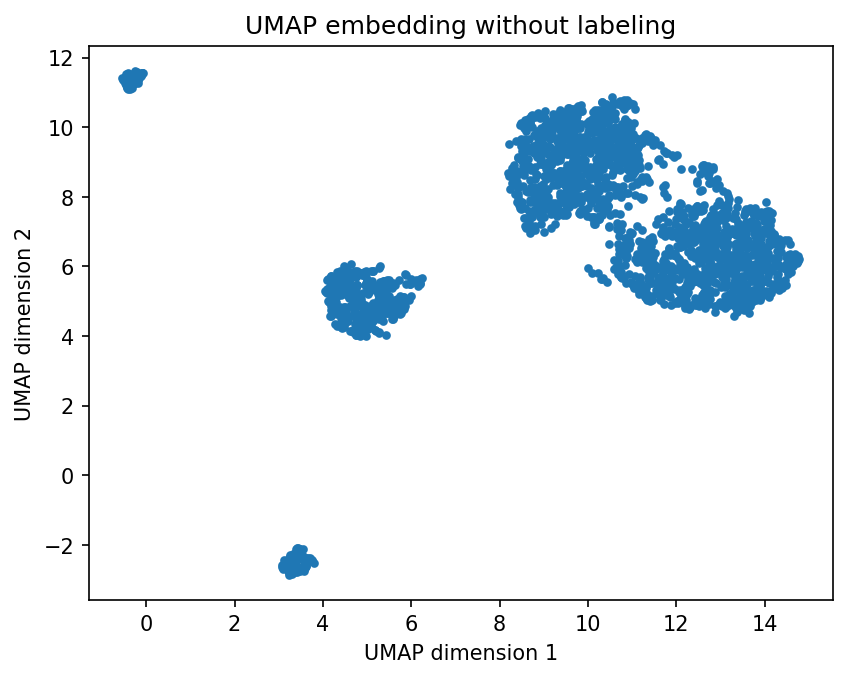

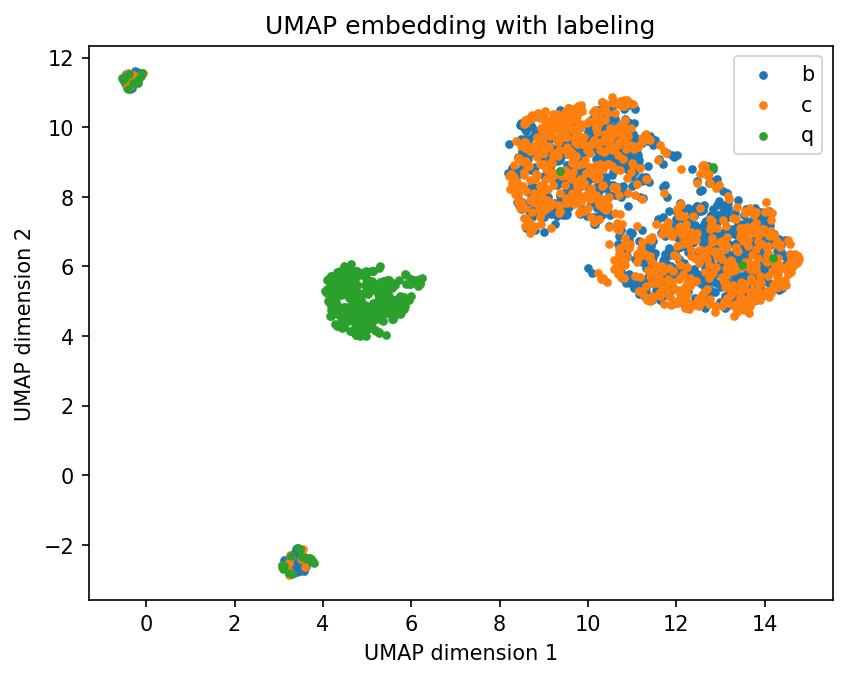

In [38]:
# TODO: make a scatterplot of the UMAP projection
plt.title('UMAP embedding without labeling')
plt.scatter(x = embedding[:,0], y = embedding[:,1], s=10)
plt.xlabel('UMAP dimension 1')
plt.ylabel('UMAP dimension 2')
plt.show()
# TODO: make a scatterplot, coloring the dots by their label and including a legend with the label names
# (hint: one way is to call plt.scatter once for each of the three possible labels)
plt.title('UMAP embedding with labeling')
for quarks, label in zip(embeds, label_names):
    plt.scatter(x = quarks[:,0], y = quarks[:,1], s=10, label = label)

plt.legend(loc='best')
plt.xlabel('UMAP dimension 1')
plt.ylabel('UMAP dimension 2')
plt.show()

Light quarks seem to seperate better from bottom and charm quarks than bottom and charm quarks with each other.

### (b)

/opt/anaconda3/envs/mlph/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:374: UserWarning: Exited at iteration 453 with accuracies 
[2.00991262e-15 1.22734448e-05 9.37833842e-06 9.16780010e-06]
not reaching the requested tolerance 1e-05.
  _, diffusion_map = lobpcg(
/opt/anaconda3/envs/mlph/lib/python3.9/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/opt/anaconda3/envs/mlph/lib/python3.9/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


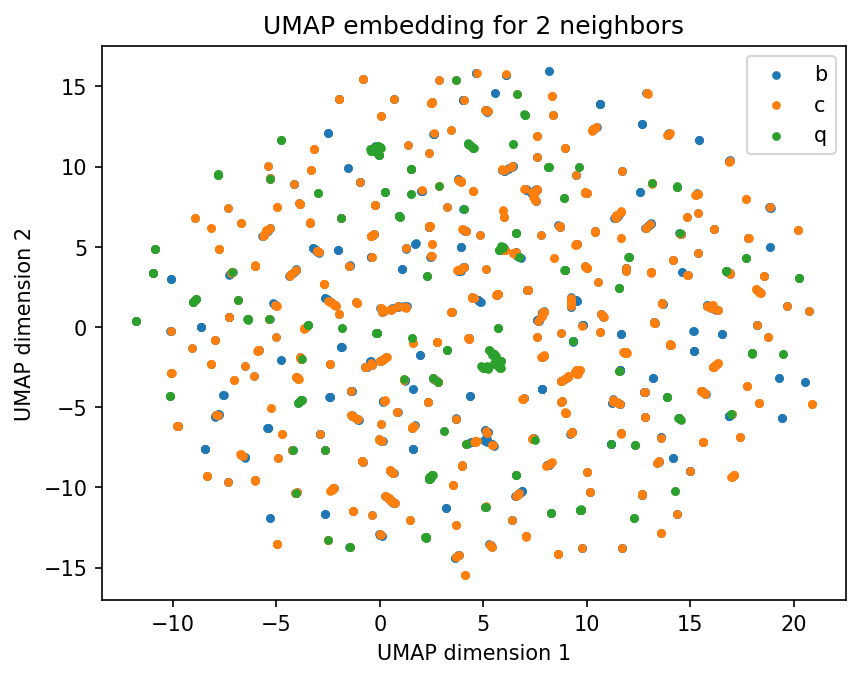

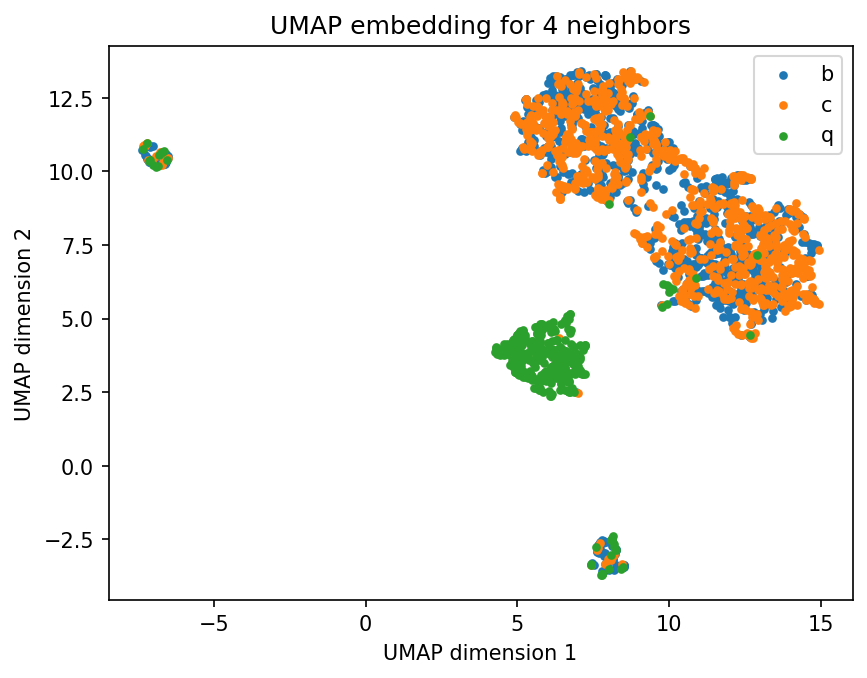

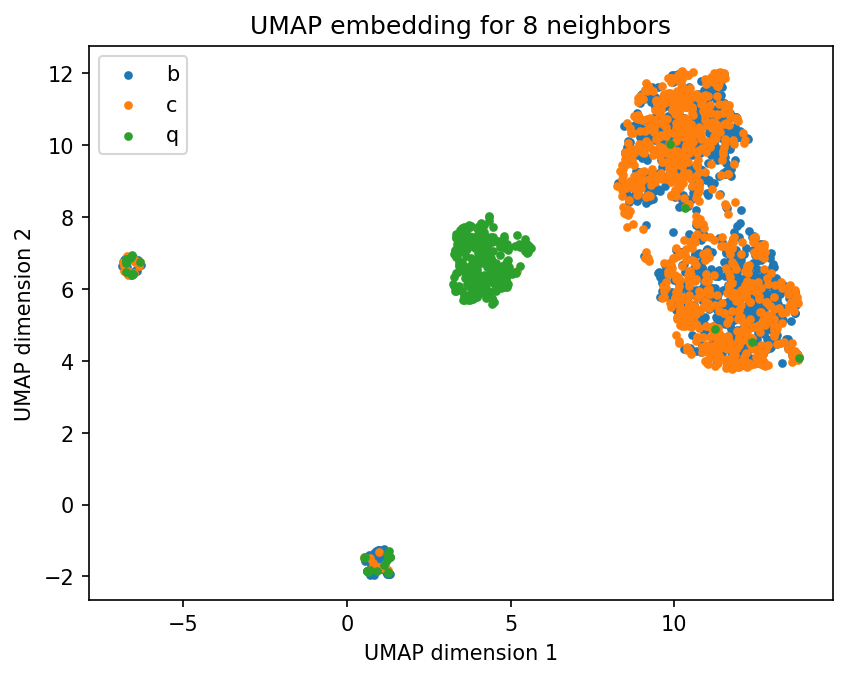

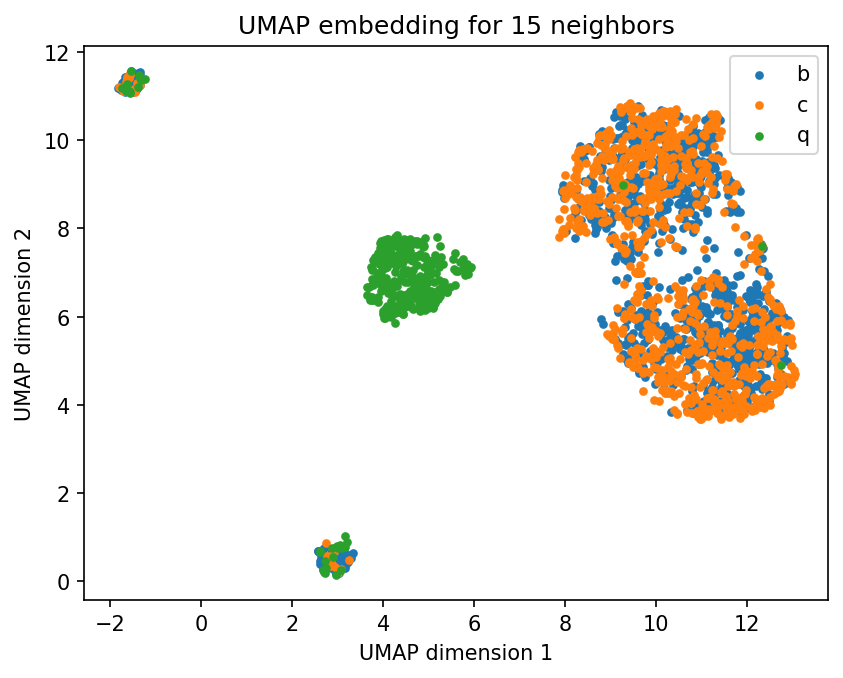

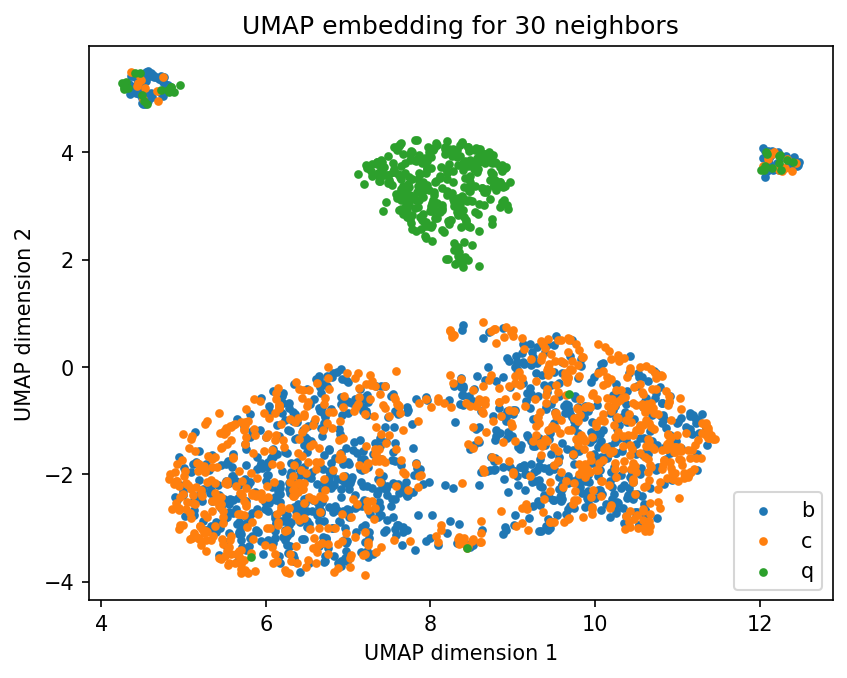

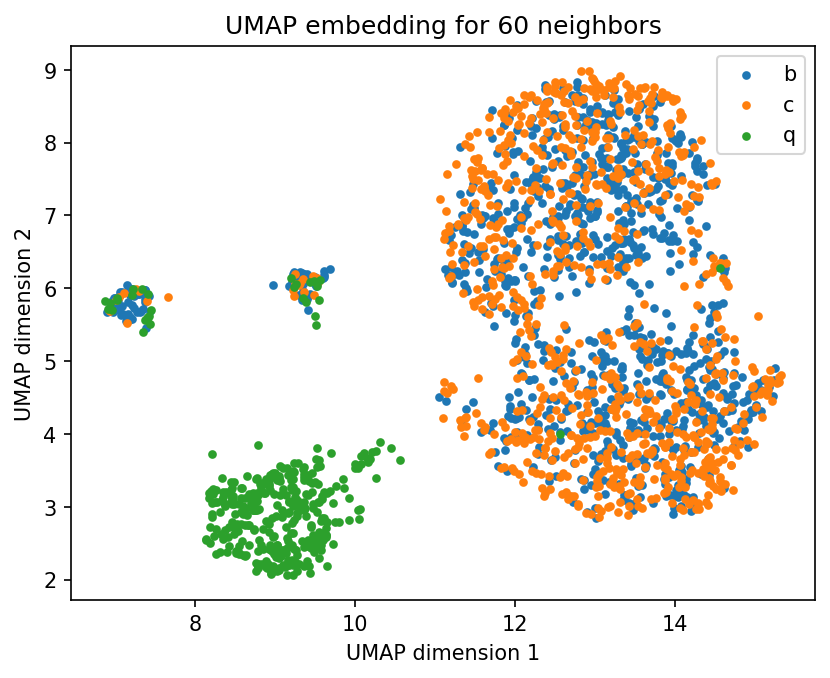

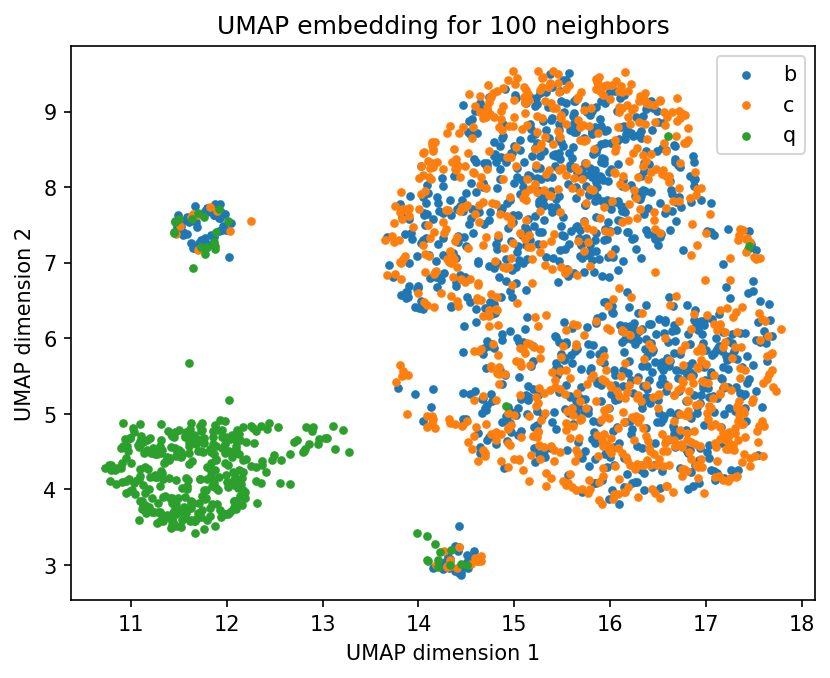

In [44]:
for n_neighbors in (2, 4, 8, 15, 30, 60, 100):
    # TODO: repeat the above, varying the n_neighbors parameter of UMAP
    reducer = umap.UMAP(n_neighbors=n_neighbors)
    embedding = reducer.fit_transform(features_t)

    embeds = [embedding[labels==int(i)] for i in np.unique(labels)]
    plt.title(f'UMAP embedding for {n_neighbors} neighbors')
    for quarks, label in zip(embeds, label_names):
        plt.scatter(x = quarks[:,0], y = quarks[:,1], s=10, label = label)
    plt.legend(loc='best')
    plt.xlabel('UMAP dimension 1')
    plt.ylabel('UMAP dimension 2')
    plt.show()

With more neighbors, the repulsive force between every data point seems to get stronger. The embedding for 30 neighbors seems to incorporate both, attraction and repulsion of the clusters well.

### (c)

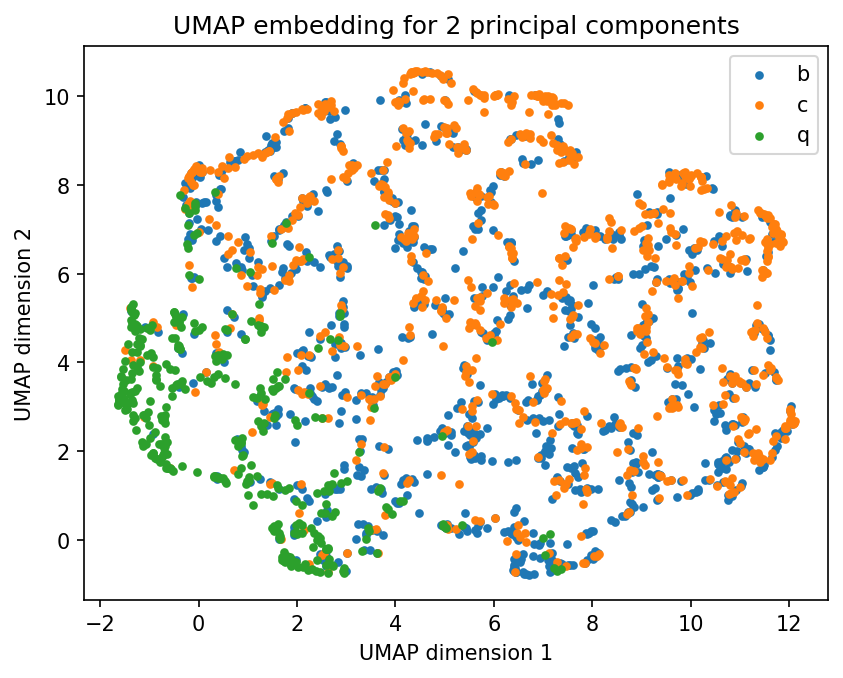

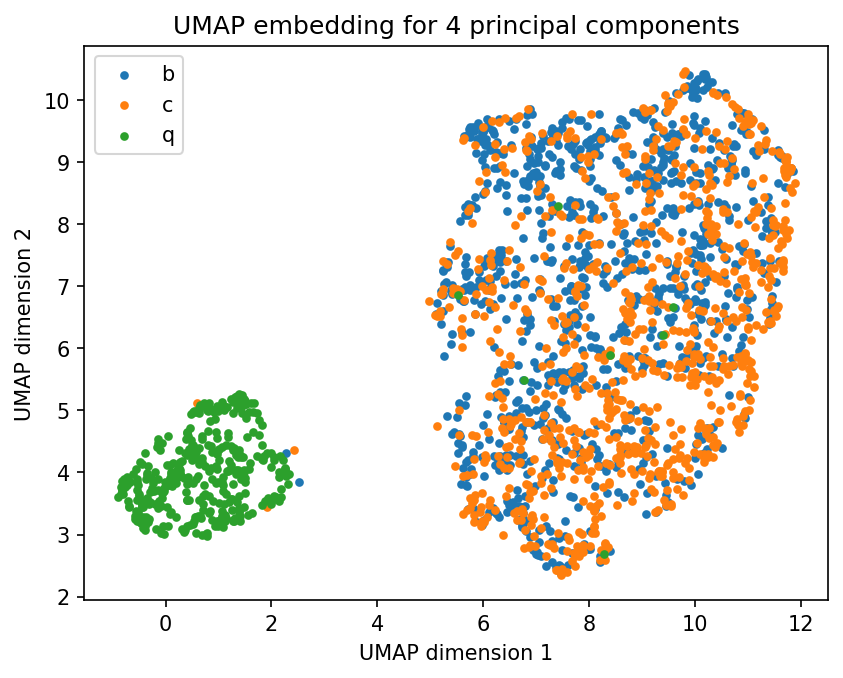

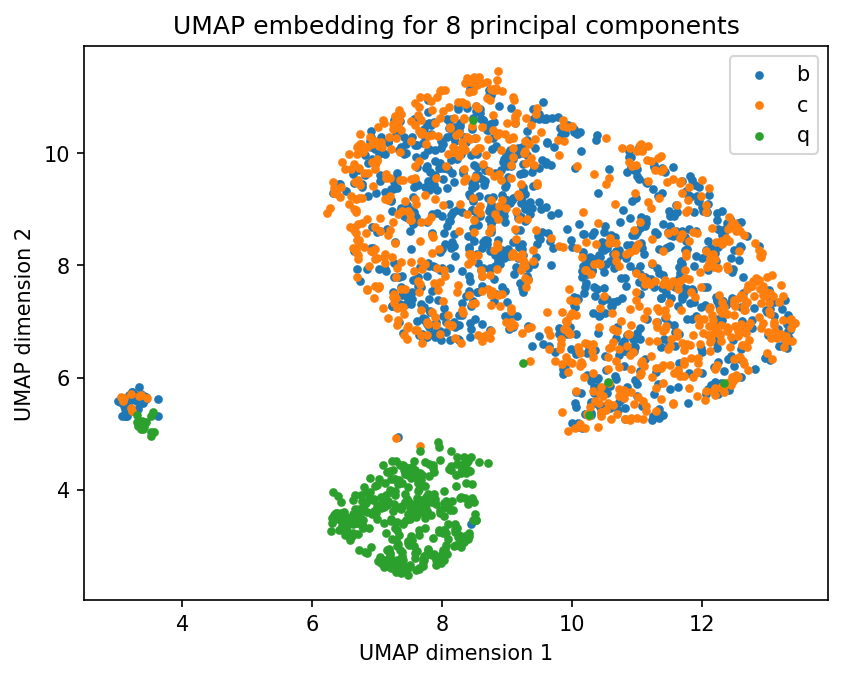

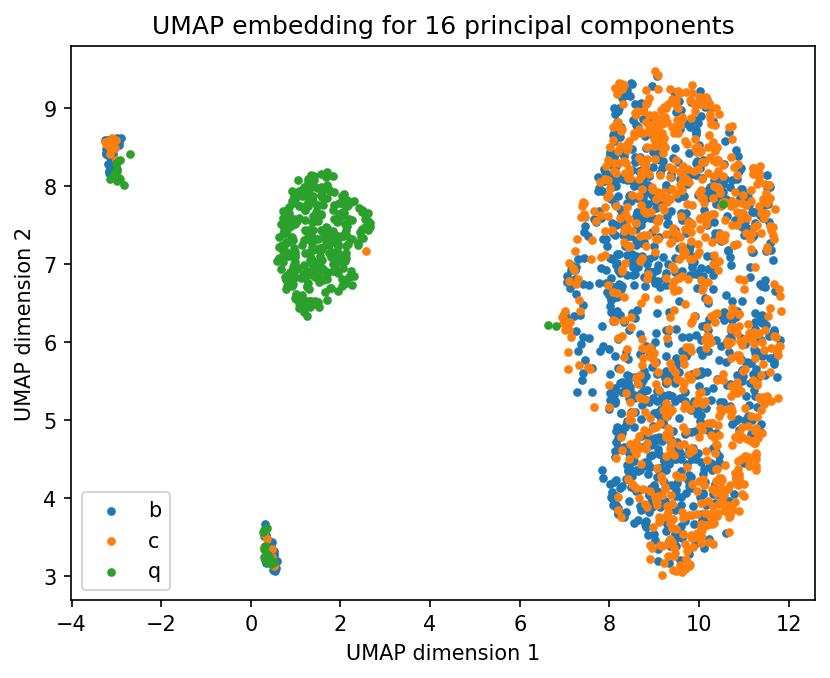

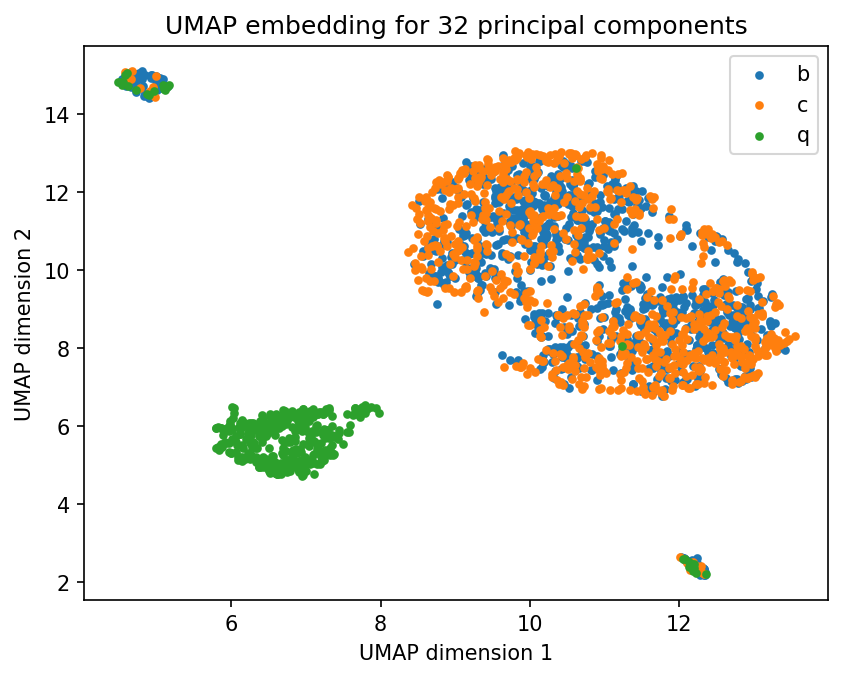

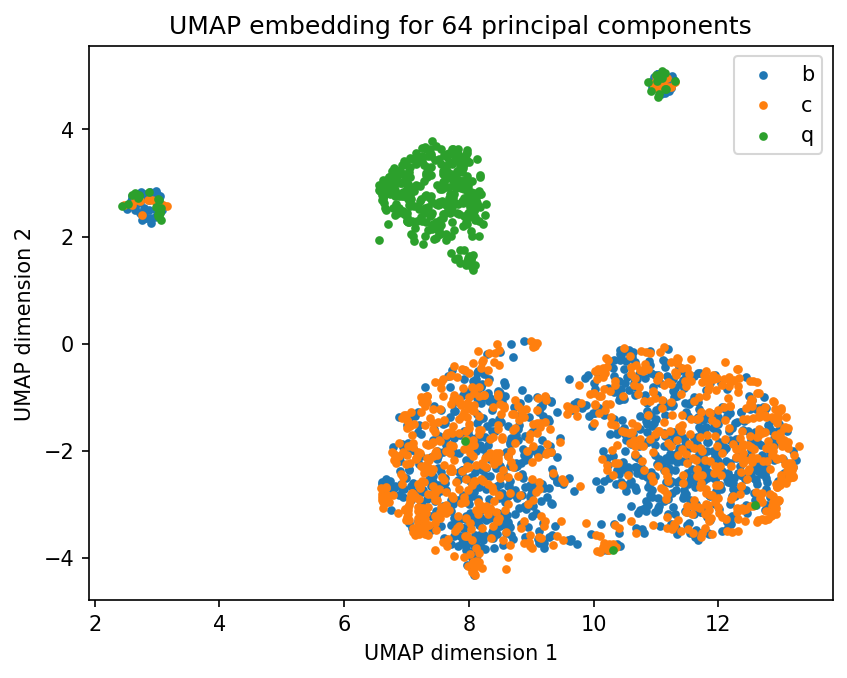

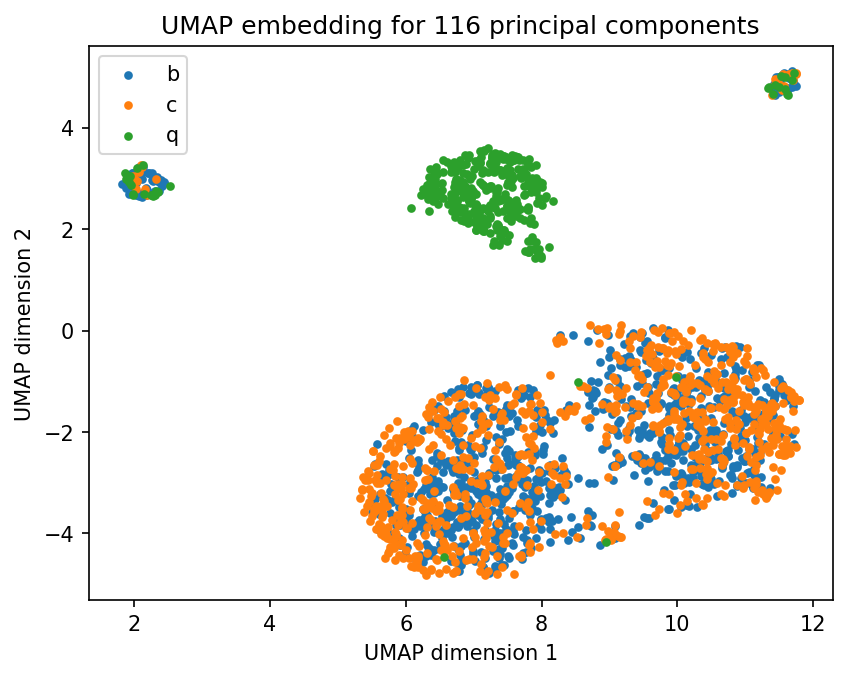

In [45]:
for n_components in (2, 4, 8, 16, 32, 64, len(features)):
    # TODO: project to the n-components first principal components 
    #       (use your implementation from ex. 1 or PCA from scikit-learn)
    components, x_projected = pca(features, n_components=n_components)
    features_t = x_projected.T
    # TODO: apply UMAP to get from n_components to just two dimensions
    reducer = umap.UMAP(n_neighbors=30) # We try 30 neighbors
    embedding = reducer.fit_transform(features_t)

    embeds = [embedding[labels==int(i)] for i in np.unique(labels)]
    plt.title(f'UMAP embedding for {n_components} principal components')
    for quarks, label in zip(embeds, label_names):
        plt.scatter(x = quarks[:,0], y = quarks[:,1], s=10, label = label)
    plt.legend(loc='best')
    plt.xlabel('UMAP dimension 1')
    plt.ylabel('UMAP dimension 2')
    plt.show()
    # TODO: again, make scatterplots as before

It seems that we can not really separate bottom and charm quarks in 2 dimensions.